In [41]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
import pyro.distributions as dist
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive

from chirho.dynamical.handlers import LogTrajectory, StaticBatchObservation
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
#num_iterations = 50 if smoke_test else 100
num_samples = 20 if smoke_test else 100
num_steps = 10 if smoke_test else 400
#sample_size = 100 if smoke_test else 300
#locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()

notebook_starts = time.time()

In [3]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]


def get_count_data_subset(count_data, start, end):
    count_subset = {key: count_data[key][start:end] for key in count_data.keys()}
    init_state = {key[:-4]: count_subset[key][0] for key in count_subset.keys()}

    return {"count_subset": count_subset, "init_state": init_state}

start = 0
end = 50
step_size = 1

logging_times = torch.arange(start, end, step_size)
start_time = torch.tensor(1).float()
end_time = torch.tensor(250 + 1).float()

c_data = get_count_data_subset(count_data, start, end)
subset = c_data["count_subset"]
init_state = c_data["init_state"]

In [ ]:
class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wander):
        super().__init__()
        self.attraction = attraction
        self.wander = wander

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        w_ee, w_es, w_se, w_sf, w_fs, w_ss = torch.unbind(self.wander)
        a_eler, a_erel, a_es, a_se, a_ef, a_sf, a_fs, a_slsr, a_srsl = torch.unbind(
            self.attraction
        )

        dX["edge_l"] = (
            -w_ee * X["edge_l"]  # 1-
            + w_ee * X["edge_r"]  # 2+
            - a_eler * X["edge_r"] * X["edge_l"]  # 3-
            + a_erel * X["edge_l"] * X["edge_r"]  # 4+
            - w_es * X["edge_l"]  # 5-
            - a_es * X["search_l"] * X["edge_l"]  # 6-
            + w_se * X["search_l"]  # 7+
            + a_se * X["edge_l"] * X["search_l"]  # 8+
            - a_ef * X["feed_l"] * X["edge_l"]
        )  # 9-

        dX["edge_r"] = (
            -w_ee * X["edge_r"]  # 2-
            + w_ee * X["edge_l"]  # 1+
            + a_eler * X["edge_r"] * X["edge_l"]  # 3+
            - a_erel * X["edge_l"] * X["edge_r"]  # 4-
            - w_es * X["edge_r"]  # 10-
            - a_es * X["search_r"] * X["edge_r"]  # 11-
            + w_se * X["search_r"]  # 12+
            + a_se * X["edge_r"] * X["search_r"]  # 13+
            - a_ef * X["feed_r"] * X["edge_r"]
        )  # 14-

        dX["search_l"] = (
            w_es * X["edge_l"]  # 5+
            - w_se * X["search_l"]  # 7-
            - w_sf * X["search_l"]  # 15-
            - w_ss * X["search_l"]  # 16-
            + w_ss * X["search_r"]  # 17+
            + w_fs * X["feed_l"]  # 23+
            - a_slsr * X["search_l"] * X["search_r"]  # 18-
            + a_srsl * X["search_l"] * X["search_r"]  # 19+
            + a_es * X["search_l"] * X["edge_l"]  # 6+
            - a_se * X["search_l"] * X["edge_l"]  # 8-
            + a_ef * X["feed_l"] * X["edge_l"]  # 9+
            - a_sf * X["feed_l"] * X["search_l"]  # 20-
            + a_fs * X["feed_l"] * X["search_l"]
        )  # 24+

        dX["search_r"] = (
            w_es * X["edge_r"]  # 10+
            - w_se * X["search_r"]  # 12-
            - w_sf * X["search_r"]  # 21-
            - w_ss * X["search_r"]  # 17-
            + w_ss * X["search_l"]  # 16+
            + a_slsr * X["search_l"] * X["search_r"]  # 18+
            - a_srsl * X["search_l"] * X["search_r"]  # 19-
            + a_es * X["search_r"] * X["edge_r"]  # 11+
            - a_se * X["search_r"] * X["edge_r"]  # # 13-
            + a_ef * X["feed_r"] * X["edge_r"]  # 14+
            - a_sf * X["feed_r"] * X["search_r"]  # 22-
            + w_fs * X["feed_r"]  # 25+
            + a_fs * X["feed_r"] * X["search_r"]  # 26+
        )

        dX["feed_l"] = (
            w_sf * X["search_l"]  # 15+
            + a_sf * X["feed_l"] * X["search_l"]  # 20+
            - w_fs * X["feed_l"]  # 23-
            - a_fs * X["feed_l"] * X["search_l"]
        )  # 24-

        dX["feed_r"] = (
            w_sf * X["search_r"]  # 21+
            + a_sf * X["feed_r"] * X["search_r"]  # 22+
            - w_fs * X["feed_r"]  # 25-
            - a_fs * X["feed_r"] * X["search_r"]  # 26-
        )

        return dX



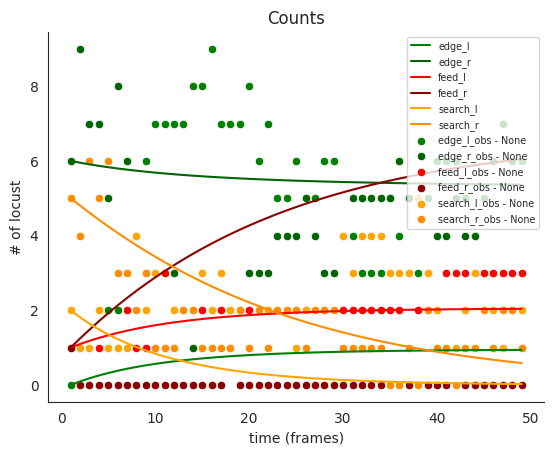

In [44]:
true_wander = torch.tensor([0.0, 0.0, 0.05, 0.05, 0.0, 0.0])
true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.00, 0.00, 0.0, 0.00, 0.00, 0.00])

locust_true = lc.LocustDynamics(true_attraction, true_wander)

with TorchDiffEq(method="rk4", ), LogTrajectory(
    logging_times
) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory

ft.plot_ds_trajectories(locust_true_traj, logging_times, window_size=0, scatter_data= subset)

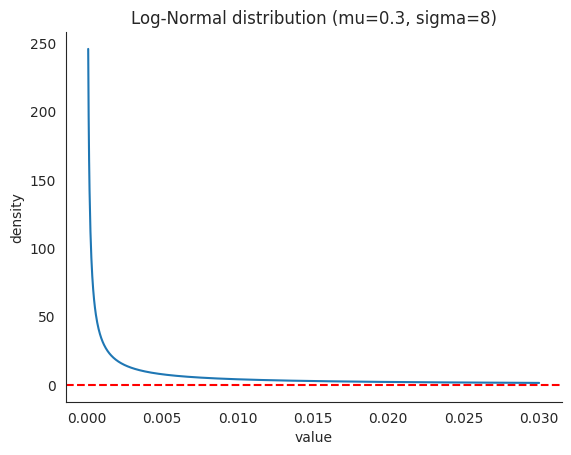

In [84]:
# for wander?
#mu = .5
#sigma =5

# for attraction?
mu = .3
sigma =8



log_normal_distribution = dist.LogNormal(mu, sigma)
plt.axhline(0, color='red', linestyle='--')  
x_values = torch.linspace(0.0001, 0.03, 1000)
pdf_values = torch.exp(log_normal_distribution.log_prob(x_values))

plt.plot(x_values.numpy(), pdf_values.numpy())
plt.title(f'Log-Normal distribution (mu={mu}, sigma={sigma})')
plt.xlabel('value')
plt.ylabel('density')
sns.despine()
plt.show()

In [8]:
guide = ft.run_svi_inference(
                model=lc.conditioned_locust_model,
                num_steps=num_steps,
                verbose=True,
                lr=0.03,
                blocked_sites=["counts_obs"],
                obs_times=logging_times,
                data=c_data['count_subset'],
                init_state=c_data['init_state'],
                start_time=start_time,
            )

/home/rafal/.local/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'counts_obs'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Running SVI for 400 steps...


/home/rafal/.local/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'counts_obs'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[iteration 0001] loss: 371.8145


KeyboardInterrupt: 